In [51]:
import numpy as np


# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from scipy.spatial import distance
from scipy.linalg import norm
from scipy.spatial.distance import euclidean
# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()
import matplotlib.pyplot as plt
import pandas as pd

In [52]:
# error probabilties, I took the following value randomly
#wondering should I take them randomly
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
measure_error = 0.2 # P(measure error)
gate_error = 0.05 # P(two qubit error)

# calling error functions using from IBM library
re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
gate_err2 = gate_err1.tensor(gate_err1)

# errors on a noisy model
bitflip_err = NoiseModel()
bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")

print(bitflip_err)



NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['measure', 'u3', 'cx', 'u1', 'reset', 'u2']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [53]:
distance_dataframe = pd.DataFrame(columns=["State Name", "Error Introduced", "TVD Distribution", 
                                           "Jensen-Shannon Distance", "Hellinger Distance 1", 
                                           "Hellinger Distance 2", "Hellinger Distance 3"])

distance_dataframe

,State Name,Error Introduced,TVD Distribution,Jensen-Shannon Distance,Hellinger Distance 1,Hellinger Distance 2,Hellinger Distance 3


In [54]:
def generate_plot(ideal_counts, calculated_counts, error_name, circ_name):
    # Match both dictionaries key 
    for key in calculated_counts:
        if key not in ideal_counts:
            ideal_counts[key] = 0
    
    for key in ideal_counts:
        if key not in calculated_counts:
            calculated_counts[key] = 0
            
    ideal_counts = dict(sorted(ideal_counts.items()))
    calculated_counts = dict(sorted(calculated_counts.items()))
    
    #Probability Distribution
    s_ideal = sum(ideal_counts.values())
    for key, value in ideal_counts.items():
        percentage = value / s_ideal
        ideal_counts[key] = percentage
        
    s_calculated = sum(calculated_counts.values())
    for key, value in calculated_counts.items():
        percentage = value / s_calculated
        calculated_counts[key] = percentage
    
    fname = f'./Images/Bar_charts/{error_name}_{circ_name}.pdf'
        
    X = np.arange(len(calculated_counts))
    f, ax = plt.subplots(figsize=(10,6))
    ax.bar(X-0.2, calculated_counts.values(), width=0.4, color='b', align='center')
    ax.bar(X+0.2, ideal_counts.values(), width=0.4, color='g', align='center')
    ax.legend(('Calculated Probability','Ideal Probability'))
    plt.xticks(X, calculated_counts.keys())
    plt.xticks(X, ideal_counts.keys())
    plt.xticks(rotation=90)
    plt.xlabel("States")
    plt.ylabel("Probability")
    plt.savefig(fname)
    plt.show()

In [55]:
def bit_error(circ, qubits, circ_name):
    import numpy as np
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Kraus, SuperOp
    from qiskit.providers.aer import AerSimulator
    from qiskit.tools.visualization import plot_histogram

    # Import from Qiskit Aer noise module
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise import QuantumError, ReadoutError
    from qiskit.providers.aer.noise import pauli_error
    from qiskit.providers.aer.noise import depolarizing_error
    from qiskit.providers.aer.noise import thermal_relaxation_error


    reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
    measure_error = 0.2 # P(measure error)
    gate_error = 0.05 # P(two qubit error)

    # calling error functions using from IBM library
    re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
    meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
    gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
    gate_err2 = gate_err1.tensor(gate_err1)

    # errors on a noisy model
    bitflip_err = NoiseModel()
    bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
    bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
    bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
    bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    sim_noise = AerSimulator(noise_model=bitflip_err)
    
    tnoise = transpile(circ, sim_noise)
    result_bit_flip = sim_noise.run(tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts()

    legend = ['ideal', 'bit_flip']

    # Plot noisy output
    
    generate_plot(ideal_counts, counts_bit_flip, 'bit_error', circ_name)
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_bit_flip.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_bit_flip:
            counts_bit_flip[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    print(' TVD Distribution')
    for key in ideal_counts:
        print(key)
        print(ideal_counts[key], counts_bit_flip[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_bit_flip[key]/N2)
        print(tvd)
    
    
    print('Jensen-Shannon Distance')
    from scipy.spatial import distance
    a = ideal_counts.values()
    b = counts_bit_flip.values()
    data_a = list(a)
    data_b = list(b)
    arr_a = np.array(data_a)
    arr_b = np.array(data_b)
    jsd = distance.jensenshannon(arr_a, arr_b)
    print(jsd)
    
    print('Hellinger Distance') 
    _SQRT2 = np.sqrt(2)
    hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
    print(hell1)
    hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
    print(hell2)
    hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
    print(hell3)
    
    distance_dataframe.loc[len(distance_dataframe.index)] = [circ_name, "Bit Error", tvd, jsd, hell1, hell2, hell3]
    
    return 

def ideal(circ):
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()

    
    return ideal_counts, ideal_counts, counts_bit_flip

In [56]:
# GHZ gate
q_ghz = QuantumRegister(3)
c_ghz = ClassicalRegister(3)
ghz_circ = QuantumCircuit(q_ghz, c_ghz)
ghz_circ.h(q_ghz[0])
ghz_circ.cx(q_ghz[0], q_ghz[1])
ghz_circ.cx(q_ghz[1], q_ghz[2])
ghz_circ.measure(q_ghz[0:3], c_ghz[0:3])
ghz_circ.draw()

┌───┐          ┌─┐      
q308_0: ┤ H ├──■───────┤M├──────
        └───┘┌─┴─┐     └╥┘┌─┐   
q308_1: ─────┤ X ├──■───╫─┤M├───
             └───┘┌─┴─┐ ║ └╥┘┌─┐
q308_2: ──────────┤ X ├─╫──╫─┤M├
                  └───┘ ║  ║ └╥┘
  c7: 3/════════════════╩══╩══╩═
                        0  1  2

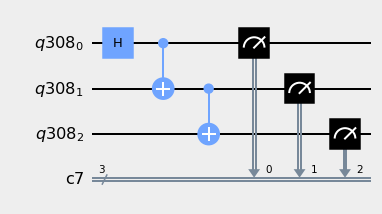

In [57]:
circuit_drawer(ghz_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/ghz_circ.pdf')

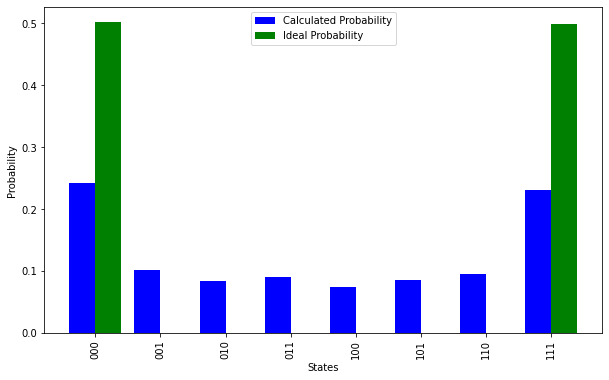

 TVD Distribution
111
510 236
0.1337890625
000
514 247
0.26416015625
101
0 87
0.306640625
010
0 86
0.3486328125
011
0 92
0.3935546875
001
0 104
0.4443359375
110
0 97
0.49169921875
100
0 75
0.5283203125
Jensen-Shannon Distance
0.6720905244155476
Hellinger Distance
24.55831123246352
24.55831123246352
24.558311232463527


In [58]:
bit_error(ghz_circ, len(q_ghz), 'GHZ')

In [59]:
def t1_t2(qubits, circ, circ_name):
    # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, qubits)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qubits)])

# Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

# QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(qubits):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    # Run the noisy simulation
    sim_thermal = AerSimulator(noise_model=noise_thermal)

    # Transpile circuit for noisy basis gates
    tthermal = transpile(circ, sim_thermal)

    # Run and get counts
    result_thermal = sim_thermal.run(tthermal).result()
    counts_thermal = result_thermal.get_counts()
    legend_t = ['ideal', 'thermal']

    # Plot noisy output
    generate_plot(ideal_counts, counts_thermal, 't1_t2', circ_name)
    
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_thermal.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_thermal:
            counts_thermal[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    print('TVD Distribution')
    for key in ideal_counts:
        print(key)
        print(ideal_counts[key], counts_thermal[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_thermal[key]/N2)
        print(tvd)
        
        
    print('Jensen-Shannon Distance')
    from scipy.spatial import distance
    a = ideal_counts.values()
    b = counts_thermal.values()
    data_a = list(a)
    data_b = list(b)
    arr_a = np.array(data_a)
    arr_b = np.array(data_b)
    jsd = distance.jensenshannon(arr_a, arr_b)
    print(jsd)
    
    print('Hellinger Distance') 
    _SQRT2 = np.sqrt(2)
    hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
    print(hell1)
    hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
    print(hell2)
    hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
    print(hell3)
    
    distance_dataframe.loc[len(distance_dataframe.index)] = [circ_name, "Thermal Error", tvd, jsd, hell1, hell2, hell3]
    
    return 

    

In [60]:
def depolar(qubits, circ, circ_name):

    p_gate = 0.1
    error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
    error_gate1 = depolarizing_error(p_gate, qubits)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_depolar = NoiseModel()
    noise_depolar.add_all_qubit_quantum_error(error_meas, "measure", qubits)
    
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()

    # Run the noisy simulation
    sim_depolar = AerSimulator(noise_model=noise_depolar)

    # Transpile circuit for noisy basis gates
    depolar = transpile(circ, sim_depolar)

    # Run and get counts
    result_depolar = sim_depolar.run(depolar).result()
    counts_depolar = result_depolar.get_counts()
    legend_t = ['ideal', 'depolar']

    # Plot noisy output
    generate_plot(ideal_counts, counts_depolar, 'depolar', circ_name)
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_depolar.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_depolar:
            counts_depolar[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    print('TVD Distribution')
    for key in ideal_counts:
        print(key)
        print(ideal_counts[key], counts_depolar[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_depolar[key]/N2)
        print(tvd)
    
    
    print('Jensen-Shannon Distance')
    from scipy.spatial import distance
    a = ideal_counts.values()
    b = counts_depolar.values()
    data_a = list(a)
    data_b = list(b)
    arr_a = np.array(data_a)
    arr_b = np.array(data_b)
    jsd = distance.jensenshannon(arr_a, arr_b)
    print(jsd)
    
    print('Hellinger Distance') 
    _SQRT2 = np.sqrt(2)
    hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
    print(hell1)
    hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
    print(hell2)
    hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
    print(hell3)
    
    distance_dataframe.loc[len(distance_dataframe.index)] = [circ_name, "Depolarizing Error", tvd, jsd, hell1, hell2, hell3]
                              
    
    return tvd, jsd, hell1, hell2, hell3

In [61]:
def tvd_calculator(dist_1, dist_2, num_qubits):
    """This function accepts two counts distributions as dictionaries
    and computes the total variation distribution (TVD) between them

    Args:
        dist1 & dist2: counts dictionary from IBM backend/simulator.
               example, {'00': 4000, '01': 4192}
        num_qubits: number of measured qubits in the qunatum circuits.

    Returns:
        tvd: Total variation distribution between two distributions
    """
    num_binary_states = 2**num_qubits

    # get the total counts for two dictionaries
    N1 = sum(dist_1.values())
    N2 = sum(dist_2.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**num_qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(num_qubits)

        if binary_state not in dist_1:
            dist_1[binary_state] = 0
        
        if binary_state not in dist_2:
            dist_2[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    for key in dist_1:
        print(dist_1[key], dist_2[key])
        tvd = tvd + 0.5 * abs(dist_1[key]/N1 - dist_2[key]/N2)

    return tvd


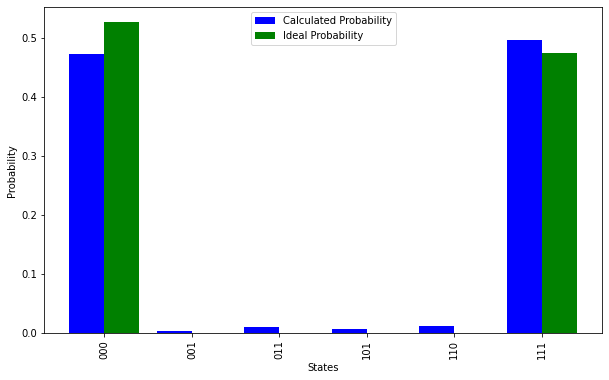

TVD Distribution
111
485 508
0.01123046875
000
539 484
0.0380859375
011
0 10
0.04296875
001
0 3
0.04443359375
101
0 7
0.0478515625
110
0 12
0.0537109375
010
0 0
0.0537109375
100
0 0
0.0537109375
Jensen-Shannon Distance
0.8125197573185431
Hellinger Distance
30.234849430554686
30.234849430554686
30.234849430554686


In [62]:
t1_t2(len(q_ghz), ghz_circ, 'GHZ')

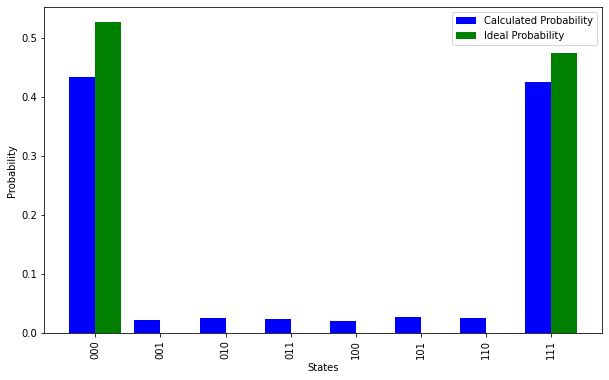

TVD Distribution
111
485 435
0.0244140625
000
539 444
0.07080078125
001
0 22
0.08154296875
101
0 27
0.0947265625
100
0 21
0.10498046875
110
0 26
0.11767578125
010
0 25
0.1298828125
011
0 24
0.1416015625
Jensen-Shannon Distance
0.7719842827761146
Hellinger Distance
28.285482006742743
28.285482006742743
28.285482006742743


(0.1416015625,
 0.7719842827761146,
 28.285482006742743,
 28.285482006742743,
 28.285482006742743)

In [63]:
depolar(len(q_ghz), ghz_circ, 'GHZ')

In [64]:
#Mermin_Bell gate
from math import pi
mer_bell = QuantumRegister(3)
mer_bell_c =  ClassicalRegister(3)
mer_bell_circ = QuantumCircuit(mer_bell, mer_bell_c)
mer_bell_circ.rx(-pi/2, mer_bell[0])
mer_bell_circ.cx(mer_bell[0], mer_bell[1])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cx(mer_bell[0], mer_bell[2])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.cx(mer_bell[2], mer_bell[0])
mer_bell_circ.cx(mer_bell[1], mer_bell[0])
mer_bell_circ.s(mer_bell[2])
mer_bell_circ.s(mer_bell[0])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cz(mer_bell[0], mer_bell[1])
mer_bell_circ.h(mer_bell[0])
mer_bell_circ.s(mer_bell[1])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.measure(mer_bell[0:3], mer_bell_c[0:3])
display(mer_bell_circ.draw())
                           

┌──────────┐                         ┌───┐┌───┐┌───┐   ┌───┐     ┌─┐   
q334_0: ┤ Rx(-π/2) ├──■──────────────■───────┤ X ├┤ X ├┤ S ├─■─┤ H ├─────┤M├───
        └──────────┘┌─┴─┐     ┌───┐  │       └─┬─┘└─┬─┘└───┘ │ ├───┤┌───┐└╥┘┌─┐
q334_1: ────────────┤ X ├──■──┤ H ├──┼────■────┼────■────────■─┤ S ├┤ H ├─╫─┤M├
                    └───┘┌─┴─┐├───┤┌─┴─┐┌─┴─┐  │  ┌───┐┌───┐┌─┐└───┘└───┘ ║ └╥┘
q334_2: ─────────────────┤ X ├┤ H ├┤ X ├┤ X ├──■──┤ S ├┤ H ├┤M├───────────╫──╫─
                         └───┘└───┘└───┘└───┘     └───┘└───┘└╥┘           ║  ║ 
  c8: 3/═════════════════════════════════════════════════════╩════════════╩══╩═
                                                             2            0  1

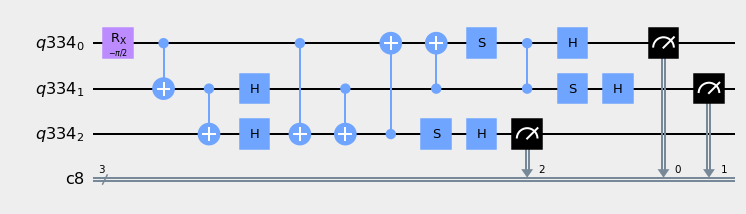

In [65]:
circuit_drawer(mer_bell_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/mer_bell_circ.pdf')

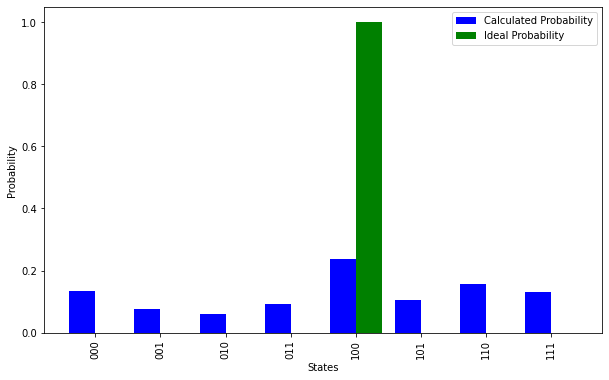

 TVD Distribution
100
1024 244
0.380859375
010
0 62
0.4111328125
111
0 134
0.4765625
011
0 95
0.52294921875
000
0 139
0.5908203125
001
0 79
0.62939453125
101
0 109
0.6826171875
110
0 162
0.76171875
Jensen-Shannon Distance
0.7596566887060396
Hellinger Distance
27.785459291356368
27.785459291356368
27.785459291356368


In [66]:
bit_error(mer_bell_circ, len(mer_bell), 'Mermin')

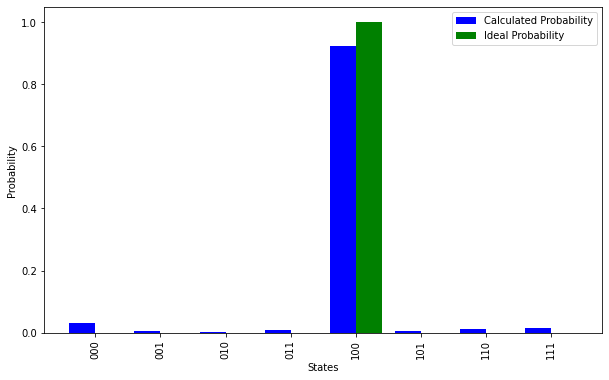

TVD Distribution
100
1024 945
0.03857421875
010
0 3
0.0400390625
001
0 4
0.0419921875
110
0 13
0.04833984375
101
0 5
0.05078125
000
0 31
0.06591796875
111
0 14
0.07275390625
011
0 9
0.0771484375
Jensen-Shannon Distance
0.8265203961954842
Hellinger Distance
31.12192754566779
31.12192754566779
31.12192754566779


In [67]:
t1_t2(len(mer_bell), mer_bell_circ, 'Mermin')

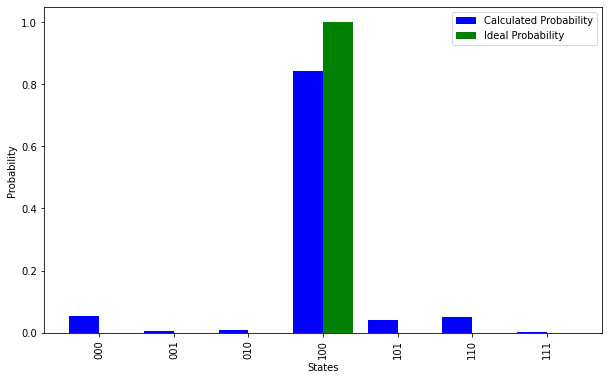

TVD Distribution
100
1024 861
0.07958984375
111
0 2
0.08056640625
000
0 54
0.10693359375
010
0 8
0.11083984375
110
0 51
0.1357421875
101
0 42
0.15625
001
0 6
0.1591796875
011
0 0
0.1591796875
Jensen-Shannon Distance
0.828297984492456
Hellinger Distance
31.284903164370846
31.284903164370846
31.284903164370846


(0.1591796875,
 0.828297984492456,
 31.284903164370846,
 31.284903164370846,
 31.284903164370846)

In [68]:
depolar(len(mer_bell), mer_bell_circ, 'Mermin')

In [69]:
#phase code
phase_q = QuantumRegister(5)
phase_c = ClassicalRegister(5)
phase_circ = QuantumCircuit(phase_q, phase_c)
phase_circ.h(phase_q[0])
phase_circ.initialize([1,0], 1)
phase_circ.x(phase_q[2])
phase_circ.initialize([1,0], 3)
phase_circ.h(phase_q[4])
phase_circ.h(phase_q[0:5])
phase_circ.cz(phase_q[0], phase_q[1])
phase_circ.h(phase_q[2])
phase_circ.h(phase_q[0])
phase_circ.cz(phase_q[1], phase_q[2])
phase_circ.h(phase_q[1])
phase_circ.cz(phase_q[2], phase_q[3])
phase_circ.h(phase_q[2])
phase_circ.cz(phase_q[3], phase_q[4])
phase_circ.h(phase_q[3])
phase_circ.h(phase_q[4])
phase_circ.barrier()
phase_circ.measure(phase_q[0:4], phase_c[0:4])
display(phase_circ.draw())


┌───┐       ┌───┐     ┌───┐                ░ ┌─┐         
q383_0: ───────┤ H ├───────┤ H ├──■──┤ H ├────────────────░─┤M├─────────
        ┌──────┴───┴──────┐├───┤  │  └───┘┌───┐           ░ └╥┘┌─┐      
q383_1: ┤ Initialize(1,0) ├┤ H ├──■────■──┤ H ├───────────░──╫─┤M├──────
        └──────┬───┬──────┘├───┤┌───┐  │  └───┘┌───┐      ░  ║ └╥┘┌─┐   
q383_2: ───────┤ X ├───────┤ H ├┤ H ├──■────■──┤ H ├──────░──╫──╫─┤M├───
        ┌──────┴───┴──────┐├───┤└───┘       │  └───┘┌───┐ ░  ║  ║ └╥┘┌─┐
q383_3: ┤ Initialize(1,0) ├┤ H ├────────────■────■──┤ H ├─░──╫──╫──╫─┤M├
        └──────┬───┬──────┘├───┤                 │  ├───┤ ░  ║  ║  ║ └╥┘
q383_4: ───────┤ H ├───────┤ H ├─────────────────■──┤ H ├─░──╫──╫──╫──╫─
               └───┘       └───┘                    └───┘ ░  ║  ║  ║  ║ 
  c9: 5/═════════════════════════════════════════════════════╩══╩══╩══╩═
                                                             0  1  2  3

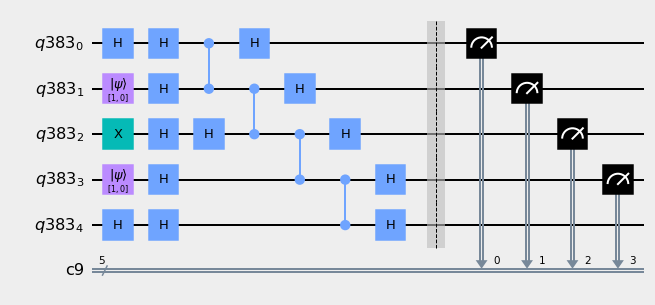

In [70]:
circuit_drawer(phase_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/phase_circ.pdf')

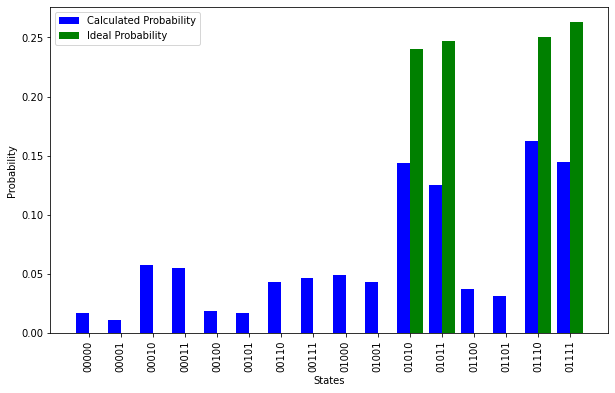

 TVD Distribution
01111
269 148
0.05908203125
01011
253 128
0.1201171875
01110
256 166
0.1640625
01010
246 147
0.21240234375
00001
0 11
0.2177734375
01001
0 44
0.2392578125
01000
0 50
0.263671875
00110
0 44
0.28515625
00100
0 19
0.29443359375
00101
0 17
0.302734375
01100
0 38
0.3212890625
00010
0 59
0.35009765625
00111
0 48
0.37353515625
00000
0 17
0.3818359375
00011
0 56
0.4091796875
01101
0 32
0.4248046875
10000
0 0
0.4248046875
10001
0 0
0.4248046875
10010
0 0
0.4248046875
10011
0 0
0.4248046875
10100
0 0
0.4248046875
10101
0 0
0.4248046875
10110
0 0
0.4248046875
10111
0 0
0.4248046875
11000
0 0
0.4248046875
11001
0 0
0.4248046875
11010
0 0
0.4248046875
11011
0 0
0.4248046875
11100
0 0
0.4248046875
11101
0 0
0.4248046875
11110
0 0
0.4248046875
11111
0 0
0.4248046875
Jensen-Shannon Distance
0.6948794136680749
Hellinger Distance
25.434611771999123
25.434611771999123
25.434611771999123


In [71]:
bit_error(phase_circ, len(phase_q), 'Phase')

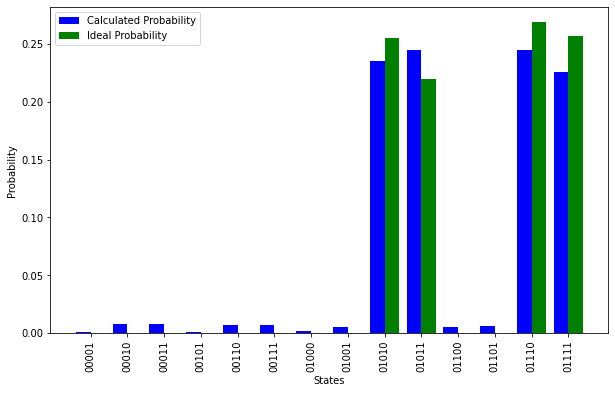

TVD Distribution
01011
225 251
0.0126953125
01110
275 251
0.0244140625
01111
263 231
0.0400390625
01010
261 241
0.0498046875
01000
0 2
0.05078125
00001
0 1
0.05126953125
01101
0 6
0.05419921875
01100
0 5
0.056640625
00101
0 1
0.05712890625
00010
0 8
0.06103515625
01001
0 5
0.0634765625
00011
0 8
0.0673828125
00111
0 7
0.07080078125
00110
0 7
0.07421875
00000
0 0
0.07421875
00100
0 0
0.07421875
10000
0 0
0.07421875
10001
0 0
0.07421875
10010
0 0
0.07421875
10011
0 0
0.07421875
10100
0 0
0.07421875
10101
0 0
0.07421875
10110
0 0
0.07421875
10111
0 0
0.07421875
11000
0 0
0.07421875
11001
0 0
0.07421875
11010
0 0
0.07421875
11011
0 0
0.07421875
11100
0 0
0.07421875
11101
0 0
0.07421875
11110
0 0
0.07421875
11111
0 0
0.07421875
Jensen-Shannon Distance
0.8112727430540206
Hellinger Distance
30.172087112829423
30.172087112829423
30.172087112829423


In [72]:
t1_t2(len(phase_q), phase_circ, 'Phase')

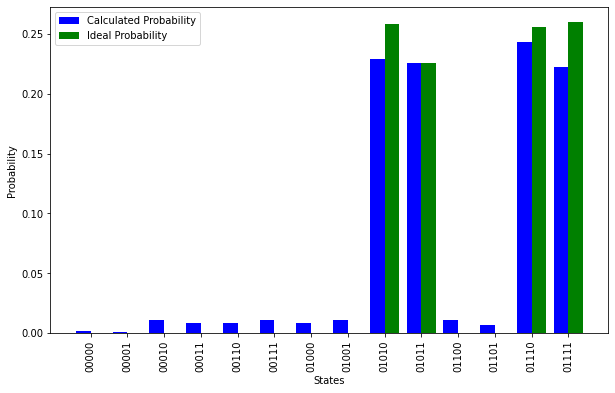

TVD Distribution
01011
231 231
0.0
01111
266 228
0.0185546875
01010
265 235
0.033203125
01110
262 249
0.03955078125
00001
0 1
0.0400390625
01000
0 9
0.04443359375
01001
0 11
0.0498046875
00010
0 11
0.05517578125
00110
0 9
0.0595703125
01100
0 11
0.06494140625
00000
0 2
0.06591796875
00111
0 11
0.0712890625
00011
0 9
0.07568359375
01101
0 7
0.0791015625
00100
0 0
0.0791015625
00101
0 0
0.0791015625
10000
0 0
0.0791015625
10001
0 0
0.0791015625
10010
0 0
0.0791015625
10011
0 0
0.0791015625
10100
0 0
0.0791015625
10101
0 0
0.0791015625
10110
0 0
0.0791015625
10111
0 0
0.0791015625
11000
0 0
0.0791015625
11001
0 0
0.0791015625
11010
0 0
0.0791015625
11011
0 0
0.0791015625
11100
0 0
0.0791015625
11101
0 0
0.0791015625
11110
0 0
0.0791015625
11111
0 0
0.0791015625
Jensen-Shannon Distance
0.790929337119036
Hellinger Distance
29.192427005695816
29.192427005695816
29.192427005695816


(0.0791015625,
 0.790929337119036,
 29.192427005695816,
 29.192427005695816,
 29.192427005695816)

In [73]:
depolar(len(phase_q), phase_circ, 'Phase')

In [74]:
#bit code
bit_q  = QuantumRegister(5)
bit_c = ClassicalRegister(5)
bit_circ = QuantumCircuit(bit_q,bit_c)
bit_circ.barrier()
bit_circ.initialize([1,0], 1)
bit_circ.x(bit_q[2])
bit_circ.initialize([1,0], 3)
bit_circ.barrier()

bit_circ.cx(bit_q[0], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[3])
bit_circ.cx(bit_q[4], bit_q[3])
bit_circ.barrier()
bit_circ.measure(bit_q[0:5],bit_c[0:5])
display(bit_circ.draw())


░                     ░                      ░ ┌─┐            
q442_0: ─░─────────────────────░───■──────────────────░─┤M├────────────
         ░ ┌─────────────────┐ ░ ┌─┴─┐┌───┐           ░ └╥┘┌─┐         
q442_1: ─░─┤ Initialize(1,0) ├─░─┤ X ├┤ X ├───────────░──╫─┤M├─────────
         ░ └──────┬───┬──────┘ ░ └───┘└─┬─┘           ░  ║ └╥┘┌─┐      
q442_2: ─░────────┤ X ├────────░────────■────■────────░──╫──╫─┤M├──────
         ░ ┌──────┴───┴──────┐ ░           ┌─┴─┐┌───┐ ░  ║  ║ └╥┘┌─┐   
q442_3: ─░─┤ Initialize(1,0) ├─░───────────┤ X ├┤ X ├─░──╫──╫──╫─┤M├───
         ░ └─────────────────┘ ░           └───┘└─┬─┘ ░  ║  ║  ║ └╥┘┌─┐
q442_4: ─░─────────────────────░──────────────────■───░──╫──╫──╫──╫─┤M├
         ░                     ░                      ░  ║  ║  ║  ║ └╥┘
 c10: 5/═════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                         0  1  2  3  4

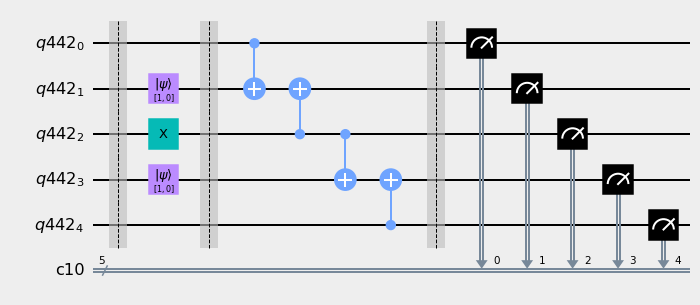

In [75]:
circuit_drawer(bit_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/bit_circ.pdf')

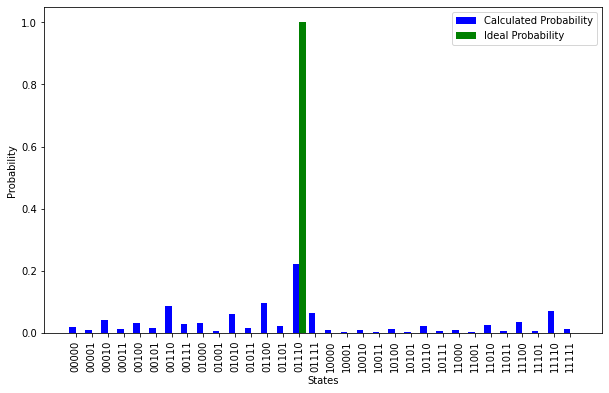

 TVD Distribution
01110
1024 226
0.3896484375
11001
0 2
0.390625
10111
0 5
0.39306640625
11000
0 8
0.39697265625
10011
0 3
0.3984375
11101
0 5
0.40087890625
10100
0 12
0.40673828125
00000
0 20
0.41650390625
01011
0 17
0.4248046875
10000
0 10
0.4296875
10101
0 3
0.43115234375
00110
0 89
0.474609375
00011
0 14
0.4814453125
00100
0 33
0.49755859375
01111
0 67
0.5302734375
10001
0 2
0.53125
01010
0 62
0.5615234375
01100
0 98
0.609375
01001
0 5
0.61181640625
00101
0 17
0.6201171875
00111
0 28
0.6337890625
00010
0 43
0.65478515625
11110
0 73
0.6904296875
11100
0 36
0.7080078125
11010
0 27
0.72119140625
00001
0 11
0.7265625
01101
0 24
0.73828125
01000
0 32
0.75390625
11011
0 5
0.75634765625
10110
0 22
0.76708984375
11111
0 14
0.77392578125
10010
0 11
0.779296875
Jensen-Shannon Distance
0.828297984492456
Hellinger Distance
31.284903164370846
31.284903164370846
31.284903164370846


In [76]:
bit_error(bit_circ, len(bit_q), 'Bit')

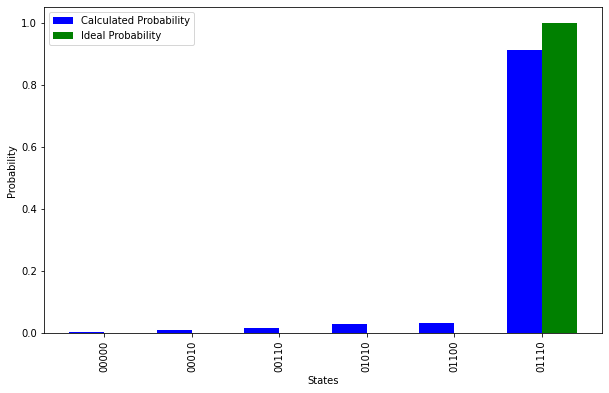

TVD Distribution
01110
1024 932
0.044921875
01010
0 31
0.06005859375
01100
0 32
0.07568359375
00000
0 4
0.07763671875
00010
0 9
0.08203125
00110
0 16
0.08984375
00001
0 0
0.08984375
00011
0 0
0.08984375
00100
0 0
0.08984375
00101
0 0
0.08984375
00111
0 0
0.08984375
01000
0 0
0.08984375
01001
0 0
0.08984375
01011
0 0
0.08984375
01101
0 0
0.08984375
01111
0 0
0.08984375
10000
0 0
0.08984375
10001
0 0
0.08984375
10010
0 0
0.08984375
10011
0 0
0.08984375
10100
0 0
0.08984375
10101
0 0
0.08984375
10110
0 0
0.08984375
10111
0 0
0.08984375
11000
0 0
0.08984375
11001
0 0
0.08984375
11010
0 0
0.08984375
11011
0 0
0.08984375
11100
0 0
0.08984375
11101
0 0
0.08984375
11110
0 0
0.08984375
11111
0 0
0.08984375
Jensen-Shannon Distance
0.7904702262119362
Hellinger Distance
29.08318311996538
29.08318311996538
29.083183119965376


In [77]:
t1_t2(len(bit_q), bit_circ, 'Bit')

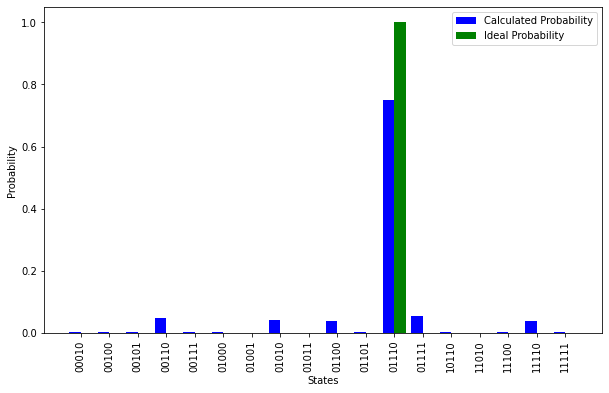

TVD Distribution
01110
1024 769
0.12451171875
11010
0 1
0.125
01100
0 40
0.14453125
01111
0 55
0.17138671875
01010
0 42
0.19189453125
00110
0 49
0.2158203125
00100
0 4
0.2177734375
11110
0 40
0.2373046875
11100
0 4
0.2392578125
00010
0 2
0.240234375
01101
0 3
0.24169921875
00111
0 2
0.24267578125
01000
0 4
0.24462890625
00101
0 2
0.24560546875
01001
0 1
0.24609375
01011
0 1
0.24658203125
10110
0 2
0.24755859375
11111
0 3
0.2490234375
00000
0 0
0.2490234375
00001
0 0
0.2490234375
00011
0 0
0.2490234375
10000
0 0
0.2490234375
10001
0 0
0.2490234375
10010
0 0
0.2490234375
10011
0 0
0.2490234375
10100
0 0
0.2490234375
10101
0 0
0.2490234375
10111
0 0
0.2490234375
11000
0 0
0.2490234375
11001
0 0
0.2490234375
11011
0 0
0.2490234375
11101
0 0
0.2490234375
Jensen-Shannon Distance
0.8302253629294643
Hellinger Distance
31.49603149604724
31.49603149604724
31.49603149604724


(0.2490234375,
 0.8302253629294643,
 31.49603149604724,
 31.49603149604724,
 31.49603149604724)

In [78]:
depolar(len(bit_q), bit_circ, 'Bit')

In [79]:
swap_qaoa_q = QuantumRegister(4)
swap_qaoa_c = ClassicalRegister(4)
swap_qaoa_circ = QuantumCircuit(swap_qaoa_q, swap_qaoa_c)
swap_qaoa_circ.h(swap_qaoa_q[0:4])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/3, 0)
swap_qaoa_circ.rz(np.pi/3, 1)
swap_qaoa_circ.rz(np.pi/3, 2)
swap_qaoa_circ.rz(np.pi/3, 3)
swap_qaoa_circ.barrier()
swap_qaoa_circ.measure(swap_qaoa_q[0:4], swap_qaoa_c[0:4])
display(swap_qaoa_circ.draw())


┌───┐                ┌───┐                                          »
q490_0: ┤ H ├──■─────────────┤ X ├──■─────────────────────────■─────────────»
        ├───┤┌─┴─┐┌─────────┐└─┬─┘┌─┴─┐           ┌───┐     ┌─┴─┐┌─────────┐»
q490_1: ┤ H ├┤ X ├┤ Rz(π/2) ├──■──┤ X ├─────■─────┤ X ├──■──┤ X ├┤ Rz(π/2) ├»
        ├───┤└───┘├─────────┤┌───┐└───┘   ┌─┴─┐   └─┬─┘┌─┴─┐└───┘└─────────┘»
q490_2: ┤ H ├──■──┤ Rz(π/2) ├┤ X ├──■─────┤ X ├─────■──┤ X ├──■─────────────»
        ├───┤┌─┴─┐└─────────┘└─┬─┘┌─┴─┐┌──┴───┴──┐     └───┘┌─┴─┐┌─────────┐»
q490_3: ┤ H ├┤ X ├─────────────■──┤ X ├┤ Rz(π/2) ├──────────┤ X ├┤ Rz(π/2) ├»
        └───┘└───┘                └───┘└─────────┘          └───┘└─────────┘»
 c11: 4/════════════════════════════════════════════════════════════════════»
                                                                            »
«        ┌───┐     ┌─────────┐                                 ░ ┌─┐         
«q490_0: ┤ X ├──■──┤ Rz(π/3) ├─────────────────────────────────░─┤M├─────────
«        └─┬─┘┌─┴─┐└─────────┘           ┌───┐     ┌─────────┐ ░ └╥┘┌─┐      
«q490_1: ──■──┤ X ├─────■────────────────┤ X ├──■──┤ Rz(π/3) ├─░──╫─┤M├──────
«        ┌───┐└───┘   ┌─┴─┐   ┌─────────┐└─┬─┘┌─┴─┐├─────────┤ ░  ║ └╥┘┌─┐   
«q490_2: ┤ X ├──■─────┤ X ├───┤ Rz(π/2) ├──■──┤ X ├┤ Rz(π/3) ├─░──╫──╫─┤M├───
«        └─┬─┘┌─┴─┐┌──┴───┴──┐└─────────┘     └───┘└─────────┘ ░  ║  ║ └╥┘┌─┐
«q490_3: ──■──┤ X ├┤ Rz(π/3) ├─────────────────────────────────░──╫──╫──╫─┤M├
«             └───┘└─────────┘                                 ░  ║  ║  ║ └╥┘
« c11: 4/═════════════════════════════════════════════════════════╩══╩══╩══╩═
«                                                                 0  1  2  3

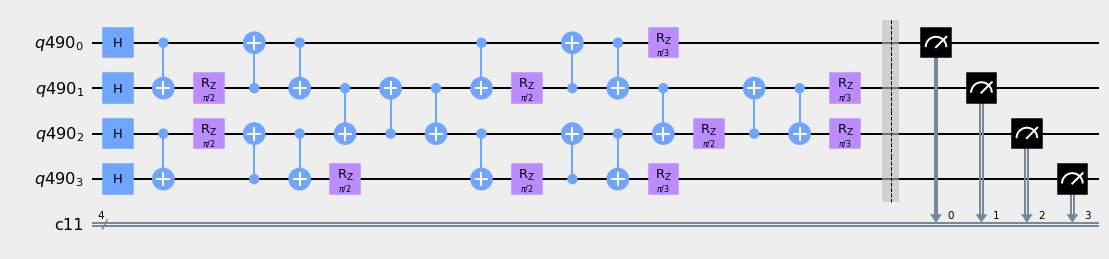

In [80]:
circuit_drawer(swap_qaoa_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/swap_qaoa_circ.pdf')

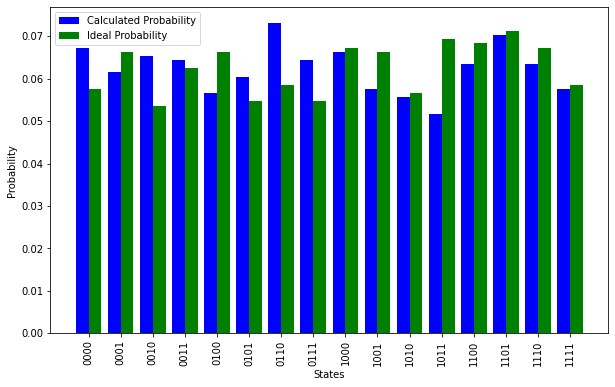

 TVD Distribution
1011
71 53
0.0087890625
0100
68 58
0.013671875
0110
60 75
0.02099609375
1110
69 65
0.02294921875
1000
69 68
0.0234375
0010
55 67
0.029296875
1101
73 72
0.02978515625
0011
64 66
0.03076171875
0111
56 66
0.03564453125
0000
59 69
0.04052734375
0101
56 62
0.04345703125
1100
70 65
0.0458984375
1001
68 59
0.05029296875
0001
68 63
0.052734375
1111
60 59
0.05322265625
1010
58 57
0.0537109375
Jensen-Shannon Distance
0.05180680414385859
Hellinger Distance
1.6586155519199974
1.6586155519199974
1.6586155519199974


In [81]:
bit_error(swap_qaoa_circ, len(swap_qaoa_q), 'Swap QAOA')

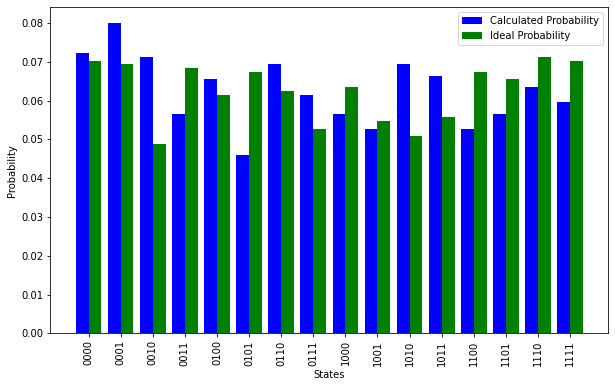

TVD Distribution
1001
56 54
0.0009765625
1110
73 65
0.0048828125
0010
50 73
0.01611328125
0001
71 82
0.021484375
1010
52 71
0.03076171875
1111
72 61
0.0361328125
0000
72 74
0.037109375
0111
54 63
0.04150390625
0011
70 58
0.04736328125
1101
67 58
0.0517578125
0100
63 67
0.0537109375
0110
64 71
0.05712890625
1100
69 54
0.064453125
0101
69 47
0.0751953125
1000
65 58
0.07861328125
1011
57 68
0.083984375
Jensen-Shannon Distance
0.05539480021799139
Hellinger Distance
1.7741983121552858
1.7741983121552858
1.7741983121552858


In [82]:
t1_t2(len(swap_qaoa_q), swap_qaoa_circ, 'Swap QAOA')

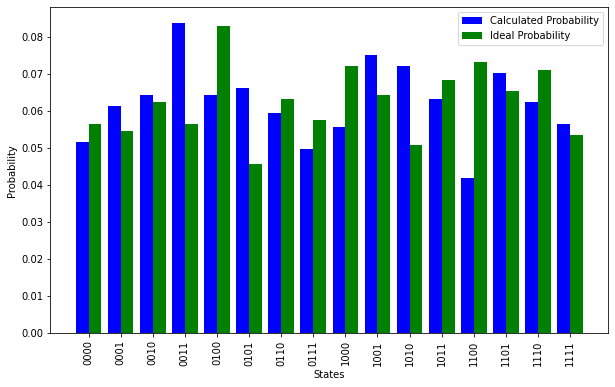

TVD Distribution
1001
66 77
0.00537109375
1101
67 72
0.0078125
0001
56 63
0.01123046875
1000
74 57
0.01953125
1011
70 65
0.02197265625
1110
73 64
0.0263671875
0111
59 51
0.0302734375
0011
58 86
0.0439453125
0000
58 53
0.04638671875
0010
64 66
0.04736328125
0101
47 68
0.0576171875
1100
75 43
0.0732421875
1111
55 58
0.07470703125
1010
52 74
0.08544921875
0110
65 61
0.08740234375
0100
85 66
0.0966796875
Jensen-Shannon Distance
0.0765228155537221
Hellinger Distance
2.4523164035023313
2.4523164035023313
2.4523164035023313


(0.0966796875,
 0.0765228155537221,
 2.4523164035023313,
 2.4523164035023313,
 2.4523164035023313)

In [83]:
depolar(len(swap_qaoa_q), swap_qaoa_circ, 'Swap QAOA')

In [84]:
vanilla_qaoa_q = QuantumRegister(3)
vanilla_qaoa_c = ClassicalRegister(3)
vanilla_qaoa_circ = QuantumCircuit(vanilla_qaoa_q, vanilla_qaoa_c)
vanilla_qaoa_circ.h(vanilla_qaoa_q[0:3])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.rz(np.pi/2, 1)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/3, 0)
vanilla_qaoa_circ.rz(np.pi/3, 1)
vanilla_qaoa_circ.rz(np.pi/3, 2)
vanilla_qaoa_circ.barrier()
vanilla_qaoa_circ.measure(vanilla_qaoa_q[0:3], vanilla_qaoa_c[0:3])
display(vanilla_qaoa_circ.draw())

┌───┐                                          ┌─────────┐           »
q527_0: ┤ H ├──■───────────────■────■───────────────■──┤ Rz(π/3) ├───────────»
        ├───┤┌─┴─┐┌─────────┐┌─┴─┐  │               │  └─────────┘           »
q527_1: ┤ H ├┤ X ├┤ Rz(π/2) ├┤ X ├──┼───────────────┼───────■────────────────»
        ├───┤└───┘└─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐   ┌─┴─┐   ┌─────────┐»
q527_2: ┤ H ├─────────────────────┤ X ├┤ Rz(π/2) ├┤ X ├───┤ X ├───┤ Rz(π/2) ├»
        └───┘                     └───┘└─────────┘└───┘   └───┘   └─────────┘»
 c12: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«                         ░ ┌─┐      
«q527_0: ─────────────────░─┤M├──────
«             ┌─────────┐ ░ └╥┘┌─┐   
«q527_1: ──■──┤ Rz(π/3) ├─░──╫─┤M├───
«        ┌─┴─┐├─────────┤ ░  ║ └╥┘┌─┐
«q527_2: ┤ X ├┤ Rz(π/3) ├─░──╫──╫─┤M├
«        └───┘└─────────┘ ░  ║  ║ └╥┘
« c12: 3/════════════════════╩══╩══╩═
«                            0  1  2

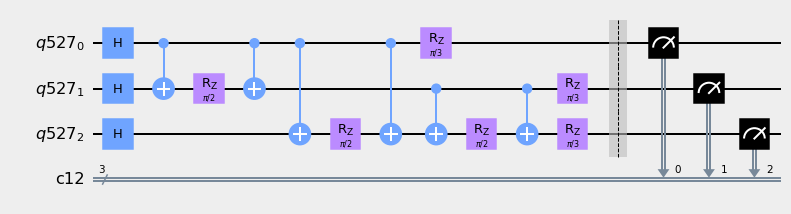

In [85]:
circuit_drawer(vanilla_qaoa_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/vanilla_qaoa_circ.pdf')

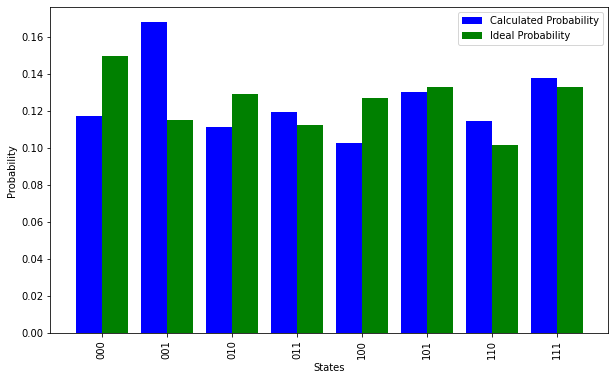

 TVD Distribution
010
132 114
0.0087890625
001
118 172
0.03515625
100
130 105
0.04736328125
110
104 117
0.0537109375
011
115 122
0.05712890625
000
153 120
0.0732421875
111
136 141
0.07568359375
101
136 133
0.0771484375
Jensen-Shannon Distance
0.06161934423817516
Hellinger Distance
1.9743090611170708
1.9743090611170708
1.9743090611170708


In [86]:
bit_error(vanilla_qaoa_circ, len(vanilla_qaoa_q), 'Vanilla QAOA')

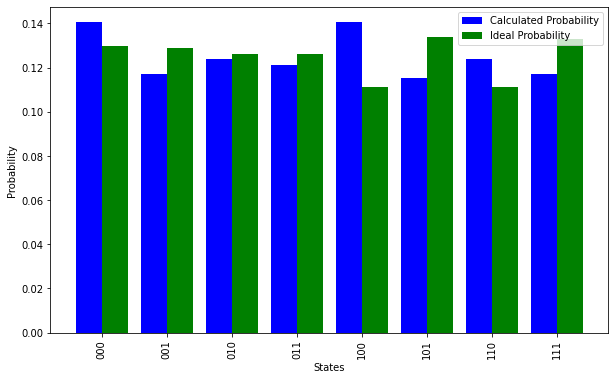

TVD Distribution
010
129 127
0.0009765625
110
114 127
0.00732421875
100
114 144
0.02197265625
001
132 120
0.02783203125
101
137 118
0.037109375
111
136 120
0.044921875
000
133 144
0.05029296875
011
129 124
0.052734375
Jensen-Shannon Distance
0.038553371922867063
Hellinger Distance
1.2341664192869137
1.2341664192869137
1.2341664192869135


In [87]:
t1_t2(len(vanilla_qaoa_q), vanilla_qaoa_circ, 'Vanilla QAOA')

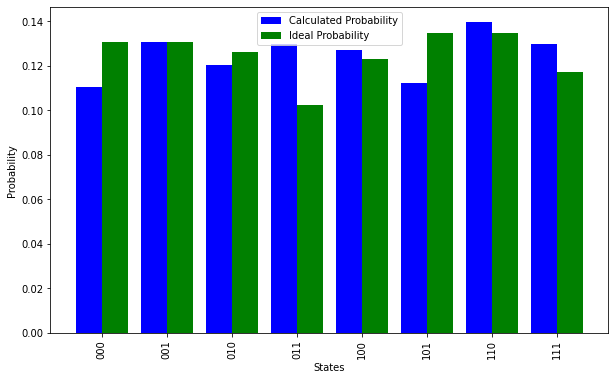

TVD Distribution
010
129 123
0.0029296875
111
120 133
0.00927734375
011
105 133
0.02294921875
000
134 113
0.033203125
110
138 143
0.03564453125
100
126 130
0.03759765625
101
138 115
0.048828125
001
134 134
0.048828125
Jensen-Shannon Distance
0.03113251305695352
Hellinger Distance
0.9964185071259596
0.9964185071259596
0.9964185071259596


(0.048828125,
 0.03113251305695352,
 0.9964185071259596,
 0.9964185071259596,
 0.9964185071259596)

In [88]:
depolar(len(vanilla_qaoa_q), vanilla_qaoa_circ, 'Vanilla QAOA')

In [89]:
hamilton_q = QuantumRegister(3)
hamilton_c = ClassicalRegister(3)
hamilton_circ = QuantumCircuit(hamilton_q, hamilton_c)
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.rz(np.pi/2, hamilton_q[0:4])
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.rz(np.pi/3, 1)
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.rz(np.pi/3, 2)
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.barrier()
hamilton_circ.measure(hamilton_q[0:3], hamilton_c[0:3])
display(hamilton_circ.draw())

┌───┐┌─────────┐┌───┐                                           ░ ┌─┐»
q564_0: ┤ H ├┤ Rz(π/2) ├┤ H ├──■───────────────■────────────────────────░─┤M├»
        ├───┤├─────────┤├───┤┌─┴─┐┌─────────┐┌─┴─┐                      ░ └╥┘»
q564_1: ┤ H ├┤ Rz(π/2) ├┤ H ├┤ X ├┤ Rz(π/3) ├┤ X ├──■───────────────■───░──╫─»
        ├───┤├─────────┤├───┤└───┘└─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐ ░  ║ »
q564_2: ┤ H ├┤ Rz(π/2) ├┤ H ├─────────────────────┤ X ├┤ Rz(π/3) ├┤ X ├─░──╫─»
        └───┘└─────────┘└───┘                     └───┘└─────────┘└───┘ ░  ║ »
 c13: 3/═══════════════════════════════════════════════════════════════════╩═»
                                                                           0 »
«              
«q564_0: ──────
«        ┌─┐   
«q564_1: ┤M├───
«        └╥┘┌─┐
«q564_2: ─╫─┤M├
«         ║ └╥┘
« c13: 3/═╩══╩═
«         1  2

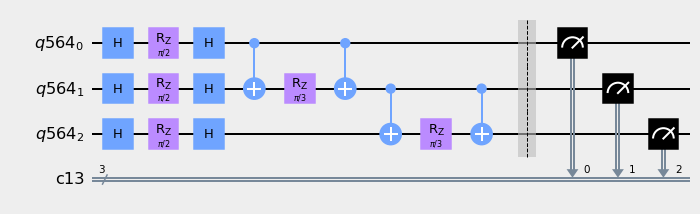

In [90]:
circuit_drawer(hamilton_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/hamilton_circ.pdf')

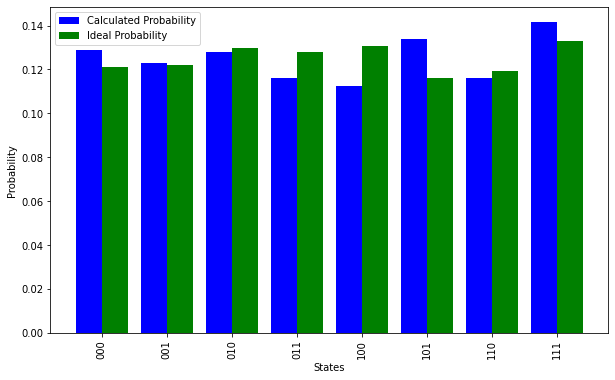

 TVD Distribution
101
119 137
0.0087890625
001
125 126
0.00927734375
100
134 115
0.0185546875
110
122 119
0.02001953125
010
133 131
0.02099609375
000
124 132
0.02490234375
111
136 145
0.029296875
011
131 119
0.03515625
Jensen-Shannon Distance
0.02339285252445331
Hellinger Distance
0.7486404629653779
0.7486404629653779
0.7486404629653779


In [91]:
bit_error(hamilton_circ, len(hamilton_q), 'Hamiltonian')

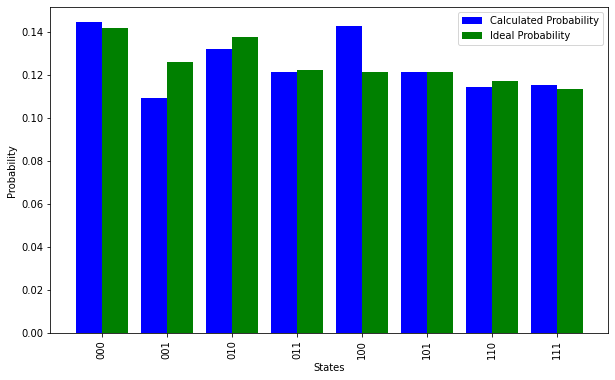

TVD Distribution
100
124 146
0.0107421875
110
120 117
0.01220703125
010
141 135
0.01513671875
111
116 118
0.01611328125
011
125 124
0.0166015625
000
145 148
0.01806640625
001
129 112
0.0263671875
101
124 124
0.0263671875
Jensen-Shannon Distance
0.03857105009981021
Hellinger Distance
1.2347549226926846
1.2347549226926846
1.2347549226926846


In [92]:
t1_t2(len(hamilton_q), hamilton_circ, 'Hamiltonian')

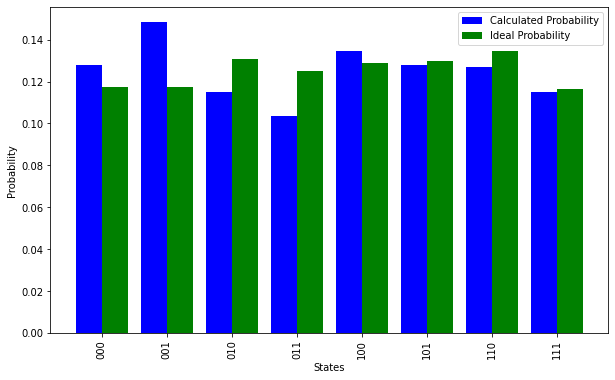

TVD Distribution
101
133 131
0.0009765625
001
120 152
0.0166015625
010
134 118
0.0244140625
100
132 138
0.02734375
110
138 130
0.03125
000
120 131
0.03662109375
111
119 118
0.037109375
011
128 106
0.0478515625
Jensen-Shannon Distance
0.03249476090546936
Hellinger Distance
1.040088555496711
1.040088555496711
1.040088555496711


(0.0478515625,
 0.03249476090546936,
 1.040088555496711,
 1.040088555496711,
 1.040088555496711)

In [93]:
depolar(len(hamilton_q), hamilton_circ, 'Hamiltonian')

# Table

In [94]:
distance_dataframe

,State Name,Error Introduced,TVD Distribution,Jensen-Shannon Distance,Hellinger Distance 1,Hellinger Distance 2,Hellinger Distance 3
0,GHZ,Bit Error,0.528320,0.672091,24.558311,24.558311,24.558311
1,GHZ,Thermal Error,0.053711,0.812520,30.234849,30.234849,30.234849
2,GHZ,Depolarizing Error,0.141602,0.771984,28.285482,28.285482,28.285482
3,Mermin,Bit Error,0.761719,0.759657,27.785459,27.785459,27.785459
4,Mermin,Thermal Error,0.077148,0.826520,31.121928,31.121928,31.121928
5,Mermin,Depolarizing Error,0.159180,0.828298,31.284903,31.284903,31.284903
6,Phase,Bit Error,0.424805,0.694879,25.434612,25.434612,25.434612
7,Phase,Thermal Error,0.074219,0.811273,30.172087,30.172087,30.172087
8,Phase,Depolarizing Error,0.079102,0.790929,29.192427,29.192427,29.192427
9,Bit,Bit Error,0.779297,0.828298,31.284903,31.284903,31.284903
